In [4]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles,smiles_to_mol
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
from rdkit.Chem import Draw
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess


In [19]:
from moses.metrics.utils import mapper,canonic_smiles
from moses.utils import get_mol


In [21]:
canonic_smiles

<function moses.metrics.utils.canonic_smiles(smiles_or_mol)>

In [ ]:
generated_graphs, generated_targets,smiles=get_generated_data('herg_karim'+'_40', generator_name='wgan',return_smiles=True)

def fraction_valid(gen, n_jobs=1):
    """
    Computes a number of valid molecules
    Parameters:
        gen: list of SMILES
        n_jobs: number of threads for calculation
    """
    gen = mapper(n_jobs)(get_mol, gen)
    return 1 - gen.count(None) / len(gen)


def fraction_unique(gen, k=None, n_jobs=1, check_validity=True):
    """
    Computes a number of unique molecules
    Parameters:
        gen: list of SMILES
        k: compute unique@k
        n_jobs: number of threads for calculation
        check_validity: raises ValueError if invalid molecules are present
    """
    if k is not None:
        if len(gen) < k:
            warnings.warn(
                "Can't compute unique@{}.".format(k) +
                "gen contains only {} molecules".format(len(gen))
            )
        gen = gen[:k]
    canonic = set(mapper(n_jobs)(canonic_smiles, gen))
    if None in canonic and check_validity:
        raise ValueError("Invalid molecule passed to unique@k")
    return len(canonic) / len(gen)


def fraction_valid(gen, n_jobs=1):
    """
    Computes a number of valid molecules
    Parameters:
        gen: list of SMILES
        n_jobs: number of threads for calculation
    """
    gen = mapper(n_jobs)(get_mol, gen)
    return 1 - gen.count(None) / len(gen)


def novelty(gen, train, n_jobs=1):
    gen_smiles = mapper(n_jobs)(canonic_smiles, gen)
    gen_smiles_set = set(gen_smiles) - {None}
    train_set = set(train)
    return len(gen_smiles_set - train_set) / len(gen_smiles_set)


def remove_invalid(gen, canonize=True, n_jobs=1):
    """
    Removes invalid molecules from the dataset
    """
    if not canonize:
        mols = mapper(n_jobs)(get_mol, gen)
        return [gen_ for gen_, mol in zip(gen, mols) if mol is not None]
    return [x for x in mapper(n_jobs)(canonic_smiles, gen) if
            x is not None]        

In [32]:
from evaluation.moses.metrics import get_all_metrics

for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(generator,dataset_name,split )
            (train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles1 =get_data(dataset_name+split, return_smiles=True)
            generated_graphs, generated_targets,smiles=get_generated_data(dataset_name+split, generator_name=generator,return_smiles=True)
           
            x=fraction_valid(smiles, n_jobs=1)
            y=fraction_valid(smiles1['train_smiles'], n_jobs=1)
            print('valid', x,y)
            print('novel', novelty(smiles, smiles1['train1_smiles']))
            x=fraction_unique(smiles, n_jobs=1)
            y=fraction_unique(smiles1['train_smiles'], n_jobs=1)
            print('unique', x,y)
            mol_metrics=get_all_metrics(gen=smiles,train=list(smiles1['train_smiles']))
            print(mol_metrics)

hiervae ames _25
valid 1.0 1.0
novel 0.9602272727272727
unique 0.13825608798114689 0.9980369061641147
{'valid': 1.0, 'unique@1000': 0.145, 'unique@10000': 0.13825608798114689, 'FCD/Test': 43.47548892368003, 'SNN/Test': 0.15007773061624588, 'Frag/Test': 0.009695998610825929, 'Scaf/Test': 0.0, 'FCD/TestSF': 44.253330897273266, 'SNN/TestSF': 0.139073268565271, 'Frag/TestSF': 0.012055070082587216, 'Scaf/TestSF': 5.129849552776289e-05, 'IntDiv': 0.9134372697936957, 'IntDiv2': 0.8022391734161626, 'Filters': 0.5899450117831894, 'logP': 2.2038268944554678, 'SA': 1.4214461277888697, 'QED': 0.42440619497343984, 'weight': 250.16577883826636, 'Novelty': 0.8465909090909091}
hiervae ames _33
valid 1.0 1.0
novel 0.967741935483871
unique 0.21908127208480566 0.9980369061641147
{'valid': 1.0, 'unique@1000': 0.283, 'unique@10000': 0.21908127208480566, 'FCD/Test': 42.53675621453302, 'SNN/Test': 0.17748508471842017, 'Frag/Test': 0.05105189489946671, 'Scaf/Test': 2.638943320099063e-05, 'FCD/TestSF': 43.4715

KeyboardInterrupt: 

In [6]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['nspdk','WL']
metrics_type=['nn', 'structural','molecular', 'auc_roc']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','stgg']

In [ ]:
from sklearn.utils import shuffle
#draw generated data
dataset_name='ames'
split='_25'
generator_name='wgan'
collected_molecules=[]
for dataset_name in ['cyp1a2_veith']:
    for split in ['_33']:
        #(train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets),smiles =get_data(dataset_name+split, return_smiles=True)
        generated_graphs, generated_targets,smiles=get_generated_data(dataset_name+split, generator_name=generator_name,return_smiles=True)
        #draw_graphs(generated_graphs[12:18],num_per_line=8)
        #print(f'Generated by {generator_name} from {dataset_name+split}')
        collected_molecules=collected_molecules+smiles_to_mol(shuffle(smiles))
Draw.MolsToGridImage(collected_molecules,molsPerRow=5
                     )

In [ ]:
Draw.MolsToGridImage(collected_molecules,molsPerRow=8
                     )

In [13]:
import pandas as pd
test=pd.read_csv('out.csv')

In [14]:
only_25=test.loc[(test.dataset=='ames_50') | (test.dataset=='bbb_martins_50') | \
                      (test.dataset=='herg_karim_50') | (test.dataset=='cyp1a2_veith_50') \
                        | (test.dataset=='cyp2c19_veith_50')| \
                       (test.dataset=='lipophilicity_astrazeneca_50')   ]

Text(0.5, 1.0, 'Molecular Weight')

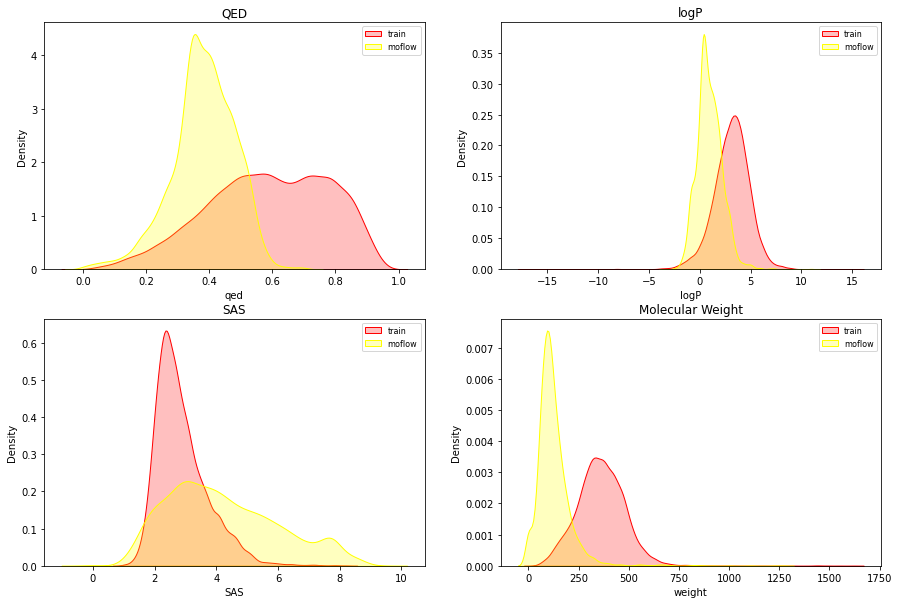

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore") 
 
generator_name='moflow'
fig,ax=plt.subplots(2,2,figsize=(15, 10))

sns.kdeplot(only_25[only_25.generator=='original']['qed'], color="red", shade=True,ax=ax[0,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['qed'], color="yellow", shade=True,ax=ax[0,0])
#sns.kdeplot(only_25[only_25.generator=='jtnn']['qed'], color="teal", shade=True,ax=ax[0,0])


ax[0,0].legend(labels=['train',generator_name],fontsize=8)
ax[0,0].set_title('QED')



sns.kdeplot(only_25[only_25.generator=='original']['logP'], color="red", shade=True,ax=ax[0,1])
sns.kdeplot(only_25[only_25.generator==generator_name]['logP'], color="yellow", shade=True,ax=ax[0,1])
ax[0,1].legend(labels=['train',generator_name],fontsize=8)
ax[0,1].set_title('logP')


sns.kdeplot(only_25[only_25.generator=='original']['SAS'], color="red", shade=True,ax=ax[1,0])
sns.kdeplot(only_25[only_25.generator==generator_name]['SAS'], color="yellow", shade=True,ax=ax[1,0])
ax[1,0].legend(labels=['train',generator_name],fontsize=8)
ax[1,0].set_title('SAS')


sns.kdeplot(only_25[only_25.generator=='original']['weight'], color="red", shade=True,ax=ax[1,1])

sns.kdeplot(only_25[only_25.generator==generator_name]['weight'], color="yellow", shade=True,ax=ax[1,1])

ax[1,1].legend(labels=['train',generator_name],fontsize=8)
ax[1,1].set_title('Molecular Weight')


In [24]:
list=[1,2,3,4]
list[:4]


[1, 2, 3, 4]